# Multi-sample Pipeline: analyzing snATAC-seq data of human colon samples

## Introduction

In this tutorial, we will perform integrative analysis of snATAC-seq data of colon sample from multiple donors. 

In [1]:
import snapatac2 as snap
import numpy as np

snap.__version__

'2.1.3.1'

Download the example dataset.

In [2]:
files = snap.datasets.colon()
files

[('colon_transverse_SM-A9VP4',
  PosixPath('/home/kaizhang/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-A9VP4_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-BZ2ZS',
  PosixPath('/home/kaizhang/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-BZ2ZS_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-A9HOW',
  PosixPath('/home/kaizhang/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-A9HOW_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-CSSDA',
  PosixPath('/home/kaizhang/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-CSSDA_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-ACCQ1',
  PosixPath('/home/kaizhang/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-ACCQ1_rep1_fragments.bed.gz'))]

First we perform preprocessing for each dataset separately.

In [3]:
%%time
h5ad_files = []
for name, fl in files:
    data = snap.pp.import_data(fl, genome=snap.genome.hg38, min_tsse=7, min_num_fragments=1000)
    snap.pp.add_tile_matrix(data)
    snap.pp.select_features(data)
    snap.pp.scrublet(data)
    snap.pp.call_doublets(data)
    
    h5ad_filename = name + ".h5ad"
    data.write(h5ad_filename)
    h5ad_files.append((name, h5ad_filename))
h5ad_files

2022-11-11 07:45:42 - INFO - Simulating doublets...
2022-11-11 07:45:42 - INFO - Spectral embedding ...
2022-11-11 07:46:16 - INFO - Calculating doublet scores...
2022-11-11 07:49:52 - INFO - Simulating doublets...
2022-11-11 07:49:52 - INFO - Spectral embedding ...
2022-11-11 07:50:49 - INFO - Calculating doublet scores...
/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
2022-11-11 07:58:05 - INFO - Simulating doublets...
2022-11-11 07:58:05 - INFO - Spectral embedding ...
2022-11-11 07:58:49 - INFO - Calculating doublet scores...
2022-11-11 08:02:42 - INFO - Simulating doublets...
2022-11-11 08:02:42 - INFO - Spectral embedding ...
2022-11-11 08:03:35 - INFO - Calculating doublet scores...
2022-11-11 08:10:41 - INFO - Simulating doublets...
2022-11-11 08:10:41 - INFO - Spectral 

CPU times: user 2h 2min 19s, sys: 2h 50min 58s, total: 4h 53min 18s
Wall time: 30min 39s


[('colon_transverse_SM-A9VP4', 'colon_transverse_SM-A9VP4.h5ad'),
 ('colon_transverse_SM-BZ2ZS', 'colon_transverse_SM-BZ2ZS.h5ad'),
 ('colon_transverse_SM-A9HOW', 'colon_transverse_SM-A9HOW.h5ad'),
 ('colon_transverse_SM-CSSDA', 'colon_transverse_SM-CSSDA.h5ad'),
 ('colon_transverse_SM-ACCQ1', 'colon_transverse_SM-ACCQ1.h5ad')]

## Creating AnnDataSet object

We then create an `AnnDataSet` object which contains links to individual data. The data are not loaded into memory so it can scale to very large dataset.

In [4]:
%%time
data = snap.AnnDataSet(adatas=h5ad_files, filename="colon.h5ads")
data

CPU times: user 20.8 s, sys: 6.16 s, total: 27 s
Wall time: 30.6 s


AnnDataSet object with n_obs x n_vars = 41810 x 6176550 backed at 'colon.h5ads'
contains 5 AnnData objects with keys: 'colon_transverse_SM-A9VP4', 'colon_transverse_SM-BZ2ZS', 'colon_transverse_SM-A9HOW', 'colon_transverse_SM-CSSDA', 'colon_transverse_SM-ACCQ1'
    obs: 'sample'
    var: 'selected'
    uns: 'AnnDataSet'

When merging multiple h5ad files, SnapATAC2 automatically adds a column to `.obs['sample']`, indicating the origin of the cells. After merging, `.obs_names` are no longer garanteed to be unique, as some barcodes may be shared across experiments. So it is advised to regenerate unique IDs by concatenating `.obs_names` and sample IDs.

In [5]:
data.obs_names = data.obs['sample'].to_numpy() + ":" + np.array(data.obs_names)

Here we use a whitelist containing all peaks we previously identified in human tissues (Zhang et al., Cell, 2021) to filter the bins. This file can be downloaded using this [link](http://renlab.sdsc.edu/kai/Key_Processed_Data/cCRE_hg38.tsv.gz). Filtering by the whitelist is optional.

In [6]:
snap.pp.select_features(data, whitelist=snap.datasets.cre_HEA())
# Use the following line to perform filtering if the whitelist is not available.
#snap.pp.select_features(data)

Although this dataset is small enough to fit into memory, for illustration purpose we will show how to use subsampling to efficiently perform the dimension reduction. Subsampling significantly reduces the memory usage and speeds up the computation.

It is as simple as spectifying `sample_size=10000` in the `tl.spectral` function, which randomly selects 10,000 cells as the landmarks to get an initial embedding, and then uses the Nystrom method to compute the embedding for the rest of cells.

In [7]:
%%time
snap.tl.spectral(data, sample_size = 10000)

2022-11-11 08:15:48 - INFO - Compute similarity matrix
2022-11-11 08:15:52 - INFO - Normalization
2022-11-11 08:15:56 - INFO - Perform decomposition
2022-11-11 08:16:06 - INFO - Perform Nystrom extension
5it [00:17,  3.47s/it]                                                                                                                                                                                


CPU times: user 2min 56s, sys: 2min 43s, total: 5min 40s
Wall time: 48.7 s


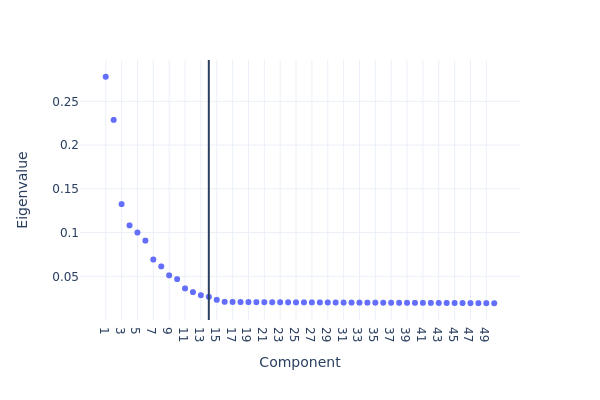

In [8]:
snap.pl.spectral_eigenvalues(data, interactive=False)

We next perform UMAP embedding and visualize the result.

In [9]:
snap.tl.umap(data, use_dims = 18)

/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning:

Tensorflow not installed; ParametricUMAP will be unavailable



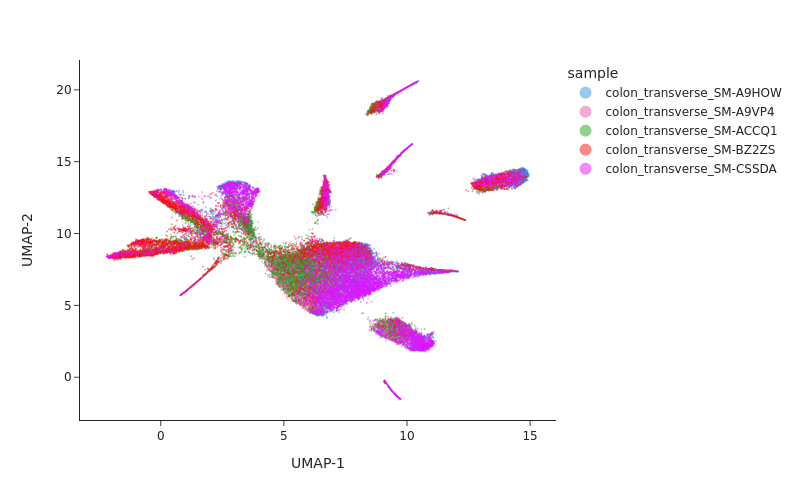

In [10]:
snap.pl.umap(data, color="sample", interactive=False, width = 800)

## Batch correction

From the UMAP plot above we can clearly see some donor/individual specific effects. Although these donor differences are interesting to study on their own, it obscures the clustering procedure for identifying shared cell states across individuals.

Here we apply two different approaches, Harmony and modified MNNCorrect, to remove donor specific differences.

In [11]:
%%time
snap.pp.mnc_correct(data, "sample", use_dims = 12)
snap.pp.harmony(data, "sample", use_dims = 12, max_iter_harmony = 20)

2022-11-11 08:18:10 - INFO - Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-11-11 08:18:10 - INFO - NumExpr defaulting to 8 threads.
2022-11-11 08:18:18,904 - harmonypy - INFO - Iteration 1 of 20
2022-11-11 08:18:18 - INFO - Iteration 1 of 20
2022-11-11 08:18:30,628 - harmonypy - INFO - Iteration 2 of 20
2022-11-11 08:18:30 - INFO - Iteration 2 of 20
2022-11-11 08:18:42,026 - harmonypy - INFO - Iteration 3 of 20
2022-11-11 08:18:42 - INFO - Iteration 3 of 20
2022-11-11 08:18:53,003 - harmonypy - INFO - Iteration 4 of 20
2022-11-11 08:18:53 - INFO - Iteration 4 of 20
2022-11-11 08:19:04,114 - harmonypy - INFO - Iteration 5 of 20
2022-11-11 08:19:04 - INFO - Iteration 5 of 20
2022-11-11 08:19:15,084 - harmonypy - INFO - Iteration 6 of 20
2022-11-11 08:19:15 - INFO - Iteration 6 of 20
2022-11-11 08:19:26,033 - harmonypy - INFO - Iteration 7 of 20
2022-11-11 08:19:26 - INFO - Iteration 7 of 20
2022-11-11 08:19:36,913 - harmonypy - INFO

CPU times: user 23min 34s, sys: 35min 56s, total: 59min 31s
Wall time: 2min 41s


Visualizing the result of MNNCorrect.

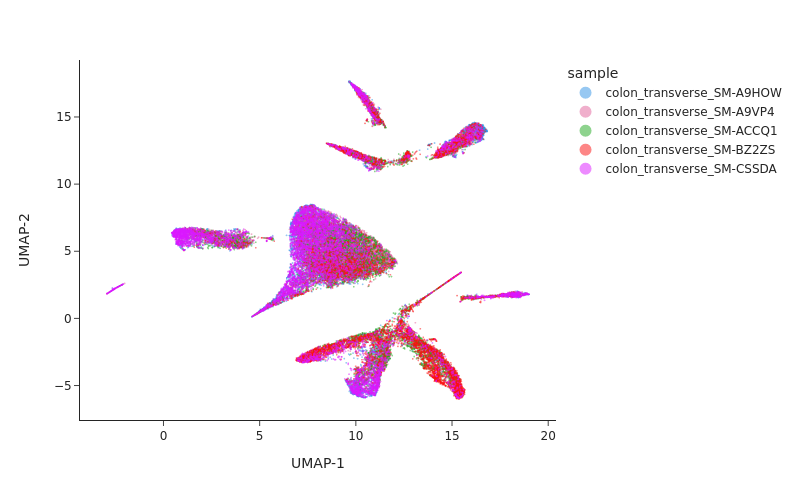

In [12]:
snap.tl.umap(data, use_rep="X_spectral_mnn")
snap.pl.umap(data, color="sample", interactive=False, width=800)

Visualize the result of Harmony.

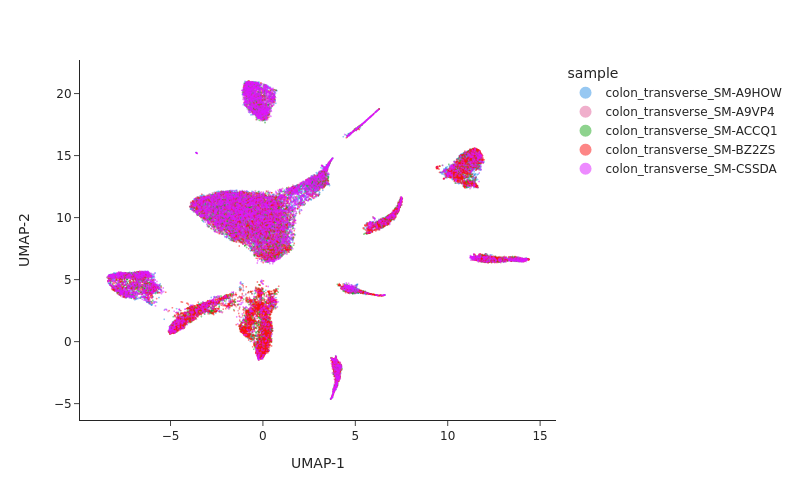

In [13]:
snap.tl.umap(data, use_rep="X_spectral_harmony")
snap.pl.umap(data, color="sample", interactive=False, width=800)

## Clustering

In [14]:
snap.pp.knn(data, use_rep="X_spectral_harmony", use_dims = 12)

In [15]:
snap.tl.leiden(data, resolution = 0.3)

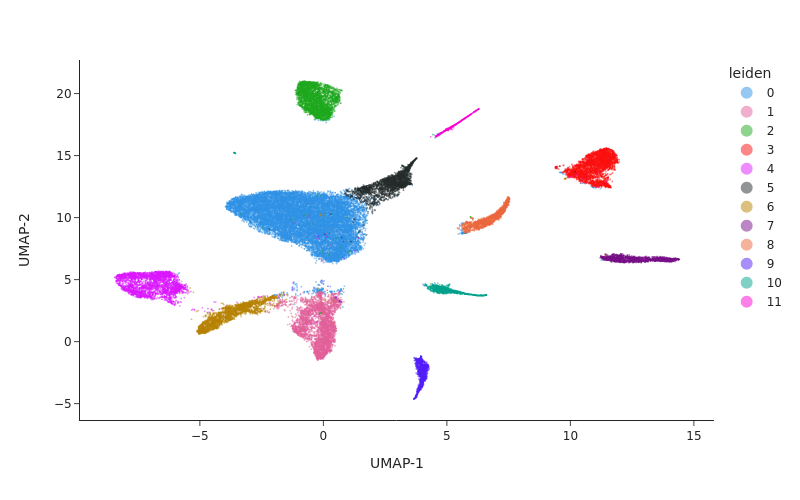

In [16]:
snap.pl.umap(data, color="leiden", interactive=False, width=800)

## AnnDataSet object IO

Just like the AnnData object, AnnDataSet object is synchronized with the content of the HDF5 file. Therefore, there is no need to manually save the result. After the analysis is finished, simply close the file by:

In [17]:
data.close()
data

Closed AnnDataSet object

The AnnDataSet object is stored as a standard h5ad file, in which the links to individual anndata file was saved in `uns['AnnDataSet']` and can be reopened by `snap.read_dataset`.

In [18]:
data = snap.read_dataset("colon.h5ads", no_check = True)
data

AnnDataSet object with n_obs x n_vars = 41810 x 6176550 backed at 'colon.h5ads'
contains 5 AnnData objects with keys: 'colon_transverse_SM-A9VP4', 'colon_transverse_SM-BZ2ZS', 'colon_transverse_SM-A9HOW', 'colon_transverse_SM-CSSDA', 'colon_transverse_SM-ACCQ1'
    obs: 'sample', 'leiden'
    var: 'selected'
    uns: 'AnnDataSet', 'spectral_eigenvalue'
    obsm: 'X_umap', 'X_spectral_harmony', 'X_spectral', 'X_spectral_mnn'
    obsp: 'distances'

Because the AnnDataSet object does not copy the underlying AnnData objects, if you move the component h5ad files then it won't be able to find them. In this case, you can supply the new locations using the `update_data_locations` parameter:

In [19]:
data.close()
data = snap.read_dataset(
    "colon.h5ads",
    update_data_locations = {"colon_transverse_SM-CSSDA": "colon_transverse_SM-CSSDA.h5ad"},
)
data

AnnDataSet object with n_obs x n_vars = 41810 x 6176550 backed at 'colon.h5ads'
contains 5 AnnData objects with keys: 'colon_transverse_SM-A9VP4', 'colon_transverse_SM-BZ2ZS', 'colon_transverse_SM-A9HOW', 'colon_transverse_SM-CSSDA', 'colon_transverse_SM-ACCQ1'
    obs: 'sample', 'leiden'
    var: 'selected'
    uns: 'AnnDataSet', 'spectral_eigenvalue'
    obsm: 'X_spectral_harmony', 'X_spectral', 'X_spectral_mnn', 'X_umap'
    obsp: 'distances'

In [20]:
data.close()